# VAE training on MNIST 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

# --- Конфигурация ---
BATCH_SIZE = 128
EPOCHS = 15
LEARNING_RATE = 3e-4
LATENT_DIM = 20
DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")

print(f"Using device: {DEVICE}")
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim) # Mean (mu)
        self.fc22 = nn.Linear(hidden_dim, latent_dim) # Log Variance (logvar)

        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        """
        The Reparameterization Trick:
        z = mu + sigma * epsilon
        """
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return mu + eps * std
        else:
            return mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)) # Sigmoid, т.к. пиксели MNIST в [0, 1]

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss = Reconstruction Loss + KL Divergence
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss: Binary Cross Entropy
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # KL Divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

model_vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model_vae.parameters(), lr=LEARNING_RATE)

Using device: mps


Using device: mps
Starting training...
Epoch: 1 | Average Loss: 203.3974
Epoch: 2 | Average Loss: 142.6047
Epoch: 3 | Average Loss: 128.2930
Epoch: 4 | Average Loss: 121.7487
Epoch: 5 | Average Loss: 118.1136
Epoch: 6 | Average Loss: 115.7144
Epoch: 7 | Average Loss: 114.0290
Epoch: 8 | Average Loss: 112.6623
Epoch: 9 | Average Loss: 111.5938
Epoch: 10 | Average Loss: 110.7191
Epoch: 11 | Average Loss: 109.9638
Epoch: 12 | Average Loss: 109.3267
Epoch: 13 | Average Loss: 108.7859
Epoch: 14 | Average Loss: 108.3124
Epoch: 15 | Average Loss: 107.9029


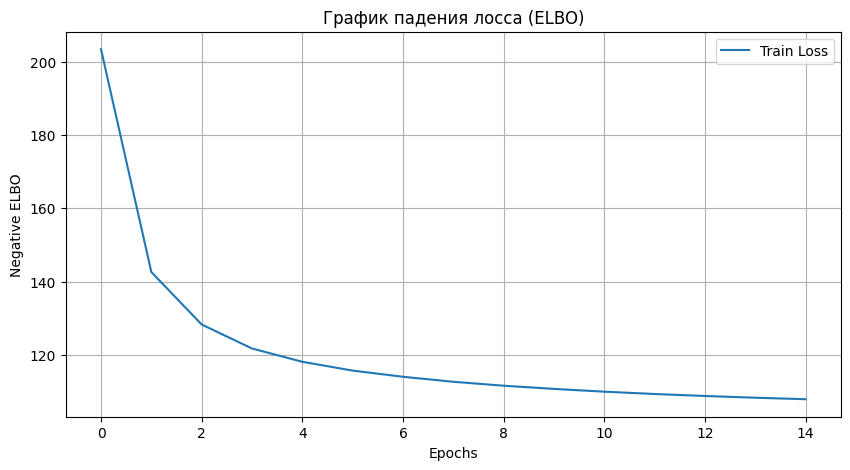

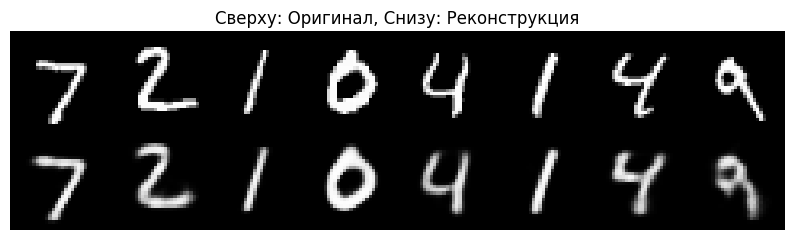

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (1x2 and 20x400)

In [ ]:
train_losses = []

print("Starting training...")
model_vae.train()
for epoch in range(EPOCHS):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(DEVICE)

        optimizer.zero_grad()

        recon_batch, mu, logvar = model_vae(data)

        loss = loss_function(recon_batch, data, mu, logvar)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch+1} | Average Loss: {avg_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.title('График падения лосса (ELBO)')
plt.xlabel('Epochs')
plt.ylabel('Negative ELBO')
plt.legend()
plt.grid(True)
plt.show()


model_vae.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(DEVICE)
    recon, _, _ = model_vae(data)

    # Сравнение оригинала и реконструкции
    n = 8
    comparison = torch.cat([data[:n], recon.view(BATCH_SIZE, 1, 28, 28)[:n]])
    grid = make_grid(comparison.cpu(), nrow=n)

    plt.figure(figsize=(10, 3))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis('off')
    plt.title('Сверху: Оригинал, Снизу: Реконструкция')
    plt.show()

In [137]:
def plot_latent_manifold(digit_size=28, n=20):
    # n - количество шагов сетки (20x20 изображений)
    figure = np.zeros((digit_size * n, digit_size * n))

    # Строим сетку значений от -3 до 3 (стандартное отклонение нормального распр.)
    grid_x = np.linspace(-3, 3, n)
    grid_y = np.linspace(-3, 3, n)[::-1] # Инвертируем Y для привычной системы координат

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(DEVICE)
            with torch.no_grad():
                x_decoded = model.decode(z_sample).cpu()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='Greys_r')
    plt.title("Латентное пространство VAE (Manifold Learning)")
    plt.axis('off')
    plt.show()

In [ ]:
# save wheights
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': avg_loss,
    'config': {
        'latent_dim': LATENT_DIM,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
    }
}, "vae_checkpoint_epoch_30.pth")

In [6]:
# load wheights

checkpoint = torch.load("vae_checkpoint_epoch_30.pth", map_location=DEVICE)
model_vae.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

In [13]:
# load wheights 

model.load_state_dict(torch.load(os.path.join(SAVE_DIR, "best_model.pth"), map_location=DEVICE))

<All keys matched successfully>

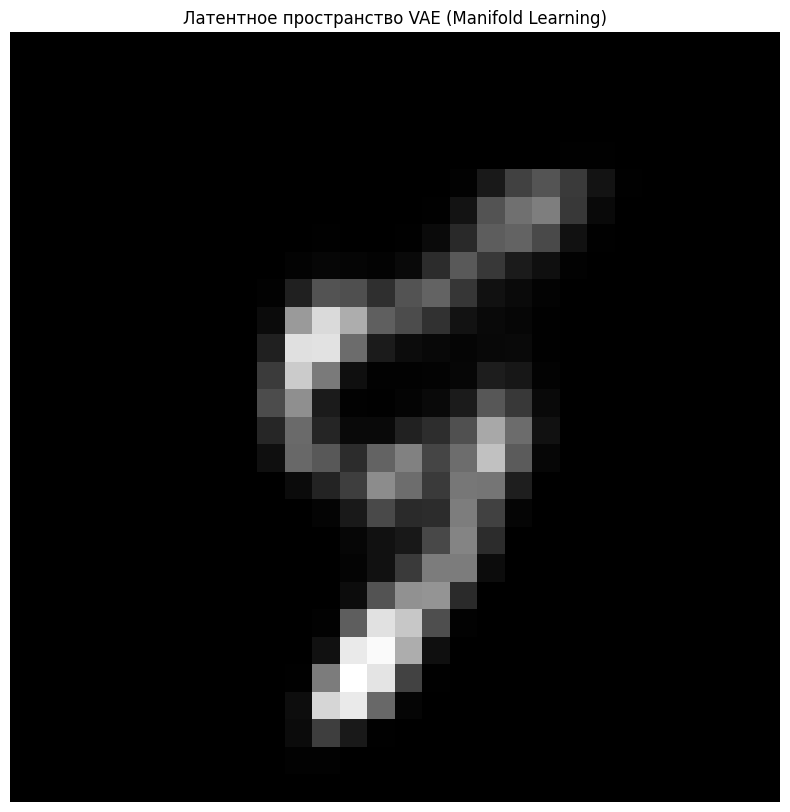

tensor([[-6.0485,  0.5327, -0.3782, -1.6840, -1.3055, -2.7710, -3.9027, -0.5849,
         -0.4153, -3.0868]], device='mps:0')


In [31]:
z = torch.randn(20, dtype=torch.float).to(DEVICE)
with torch.no_grad():
    x_decoded = model_vae.decode(z).cpu()
digit = x_decoded.reshape(28, 28)
plt.figure(figsize=(10, 10))
plt.imshow(digit, cmap='Greys_r')
plt.title("Латентное пространство VAE (Manifold Learning)")
plt.axis('off')
plt.show()
with torch.no_grad():
    data = digit.reshape((1,1,28,28)).to(DEVICE)
    output = model(data)
    print(output)

Loaded batch shape: torch.Size([1000, 1, 28, 28])
mu shape: torch.Size([1000, 20])
Successfully generated interpolated data.
Generated data shape: torch.Size([1000, 1, 28, 28])
Saved tensor to data/generated/vae_mnist_samples.pt


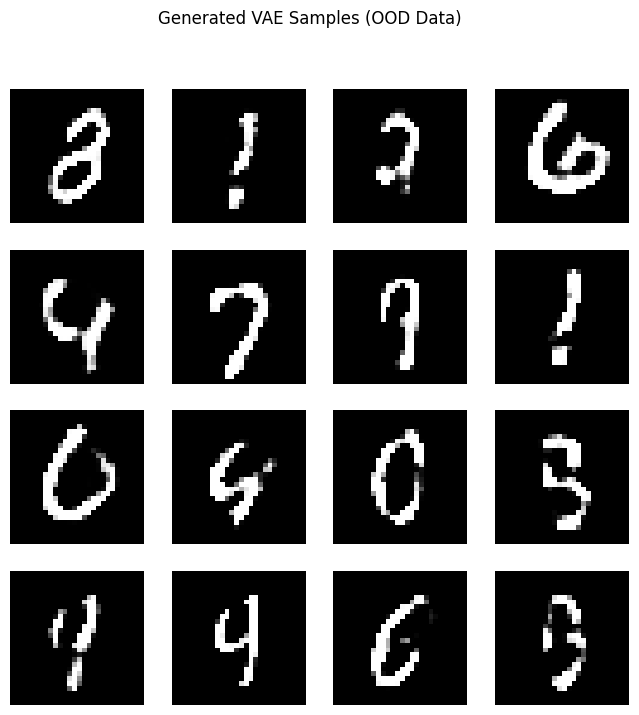

In [ ]:
from pathlib import Path

NUM_SAMPLES = 1000 
OUTPUT_DIR = Path("data/generated")
OUTPUT_FILENAME = "vae_mnist_samples.pt"

large_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transform),
    batch_size=1000, 
    shuffle=True
)

real_imgs = next(iter(large_loader))[0].to(DEVICE)
print(f"Loaded batch shape: {real_imgs.shape}") 

with torch.no_grad():
    flat_imgs = real_imgs.view(-1, 784) 
    mu, _ = model_vae.encode(flat_imgs[0:1000])    
    x_decoded = model_vae.decode(mu)
    generated_data = x_decoded.view(1000, 1, 28, 28)

print("Successfully generated interpolated data.")
print(f"Generated data shape: {generated_data.shape}")


OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
save_path = OUTPUT_DIR / OUTPUT_FILENAME

torch.save(generated_data.cpu(), save_path)
print(f"Saved tensor to {save_path}")

# Plot the first 16 images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = generated_data[i].cpu().squeeze() # Remove channel dim for plotting
    ax.imshow(img, cmap='Greys_r')
    ax.axis('off')

plt.suptitle("Generated VAE Samples (OOD Data)")
plt.show()

# Simple cnn classifier for MNSIT

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset


class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, 3, 1)  
        self.conv2 = nn.Conv2d(4, 8, 3, 1)
        self.fc1 = nn.Linear(1152, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [126]:
# Configuration
batch_size = 128
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

# Load MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
mnist_train_full = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, transform=transform)

# Split Train into Train (45k) and Calibration (15k)
# The paper uses calibration data to learn the "normal" range of uncertainty
train_size = 45000
calib_size = 15000
train_dataset, calib_dataset = torch.utils.data.random_split(mnist_train_full, [train_size, calib_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# We need full tensors for the mdu library functions usually
X_calib_tensor = torch.stack([t[0] for t in calib_dataset]).to(device)
y_calib_tensor = torch.tensor([t[1] for t in calib_dataset]).to(device)
X_test_tensor = torch.stack([t[0] for t in mnist_test]).to(device)

In [ ]:
vae_data_path = "data/generated/vae_mnist_samples.pt"
X_vae_tensor = torch.load(vae_data_path).to(device)

In [127]:
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

# Train ensemble of simple classifiers

In [128]:
n_members = 5 # Important: Use > 1
ensemble = [MNISTNet().to(device) for _ in range(n_members)]

print("Training Ensemble...")
for i, model in enumerate(ensemble):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(1): # Train for a few epochs
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = nn.CrossEntropyLoss()(output, target)
            loss.backward()
            optimizer.step()
    print(f"Model {i+1} trained.")

Training Ensemble...
Model 1 trained.
Model 2 trained.
Model 3 trained.
Model 4 trained.
Model 5 trained.


# Metrics

In [129]:
for idx, model_ens in enumerate(ensemble): 
    print("Model", idx, "accuracy", evaluate(model_ens, test_loader)[1])

Model 0 accuracy 95.98
Model 1 accuracy 94.78
Model 2 accuracy 94.22
Model 3 accuracy 94.17
Model 4 accuracy 95.23


# Import VecUQ classes for uncertanity scores calculation.

In [130]:
from multidimensional_uncertainty.mdu.eval.eval_utils import get_ensemble_predictions
from multidimensional_uncertainty.configs.uncertainty_measures_configs import (
    MAHALANOBIS_AND_BAYES_RISK, EAT_M
)
from multidimensional_uncertainty.mdu.unc.multidimensional_uncertainty import (
    fit_and_apply_uncertainty_estimators,
    pretty_compute_all_uncertainties,
)
from multidimensional_uncertainty.mdu.unc.entropic_ot import EntropicOTOrdering
from multidimensional_uncertainty.mdu.unc.constants import OTTarget, SamplingMethod, ScalingType

In [131]:
print("Getting Logits...")
# 1. Calibration Data (ID)
logits_calib = get_ensemble_predictions(ensemble, X_calib_tensor, return_logits=True)

# 2. Test Data (ID)
logits_test_id = get_ensemble_predictions(ensemble, X_test_tensor, return_logits=True)

# 3. Generated Data (OOD)
logits_test_ood = get_ensemble_predictions(ensemble, X_vae_tensor, return_logits=True)

Getting Logits...


# Using 4 uncertanity measures config as in article

In [ ]:

UNCERTAINTY_MEASURES = EAT_M 
# Fit estimators (e.g., calculate Mahalanobis mean/cov on calibration data)
pretty_scores_calib, fitted_estimators = fit_and_apply_uncertainty_estimators(
    uncertainty_configs=UNCERTAINTY_MEASURES,
    X_calib_logits=logits_calib, 
    y_calib=y_calib_tensor.to("cpu"),
    X_test_logits=logits_calib, 
)

# Stack calibration scores into a matrix (N_calib x 4)
scores_calib_matrix = np.column_stack([scores for _, scores in pretty_scores_calib])

# Fit VecUQ-OT

In [133]:
ot_model = EntropicOTOrdering(
    target=OTTarget.BETA,
    sampling_method=SamplingMethod.RANDOM, # Use RANDOM instead of GRID
    scaling_type=ScalingType.FEATURE_WISE,
    grid_size=2000,        # Number of random samples from the target distribution
    target_params={},      # Uses default Beta parameters
    eps=0.5,               # Regularization for Sinkhorn
    n_targets_multiplier=1,
    random_state=42,
    max_iters=10,
    tol=1e-6
)

print("Fitting OT...")
ot_model.fit(scores_cal=scores_calib_matrix)

Fitting OT...


/Users/georgij/Documents/homework/iitp/bayssian_methods/venv/lib/python3.10/site-packages/ot/bregman/_sinkhorn.py:902: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(
/Users/georgij/Documents/homework/iitp/bayssian_methods/venv/lib/python3.10/site-packages/ot/backend.py:1203: RuntimeWarning: overflow encountered in exp
  return np.exp(a)


# Apply to Test and VAE

In [134]:
# 1. Compute components for ID Test
pretty_scores_id = pretty_compute_all_uncertainties(
    uncertainty_estimators=fitted_estimators,
    logits_test=logits_test_id
)
scores_id_matrix = np.column_stack([s for _, s in pretty_scores_id])

# 2. Compute components for OOD (VAE)
pretty_scores_ood = pretty_compute_all_uncertainties(
    uncertainty_estimators=fitted_estimators,
    logits_test=logits_test_ood
)
scores_ood_matrix = np.column_stack([s for _, s in pretty_scores_ood])

# 3. Get Final Scalar Scores via OT
final_scores_id = ot_model.predict(scores_id_matrix)   # Expecting Low values
final_scores_ood = ot_model.predict(scores_ood_matrix) # Expecting High values

In [135]:
from sklearn.metrics import roc_auc_score

# Create labels: 0 for ID (MNIST), 1 for OOD (VAE)
y_true = np.concatenate([np.zeros(len(final_scores_id)), np.ones(len(final_scores_ood))])
y_scores = np.concatenate([final_scores_id, final_scores_ood])

auc = roc_auc_score(y_true, y_scores)
print(f"ROC-AUC Score (MNIST vs VAE): {auc:.4f}")

ROC-AUC Score (MNIST vs VAE): 0.9988



Results:
------------------------------
AUC (Total Risk / Entropy): 0.9797
AUC (VecUQ-OT)           : 0.9988
------------------------------
SUCCESS: VecUQ-OT outperformed simple Entropy!


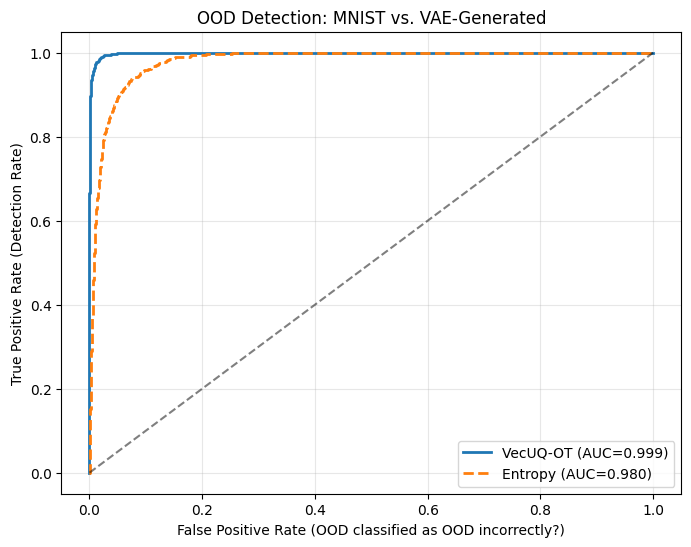

In [136]:
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# --- 1. Extract "Total Risk" (Entropy) ---
# In the 'pretty_scores' list, we need to find the column corresponding to Total Risk.
# Typically, if you used standard configs, Total Risk (Entropy) is often the first component.
# Let's verify by checking the names in the dictionary keys.

# Helper to find the index of Total Risk (Entropy)
def get_entropy_scores(pretty_scores_list):
    # pretty_scores_list is a list of tuples: (name, scores_array)
    # We look for "Total" or "Entropy" in the name
    for name, scores in pretty_scores_list:
        if "Total" in name or "Entropy" in name:
            print(f"Found Entropy component: {name}")
            return scores
    # Fallback: usually the first component in standard decompositions
    print("Warning: explicit 'Total' not found, using first component as proxy.")
    return pretty_scores_list[0][1]

entropy_id = get_entropy_scores(pretty_scores_id)
entropy_ood = get_entropy_scores(pretty_scores_ood)

# --- 2. Prepare Labels and Scores for ROC ---
# 0 = ID (MNIST Test), 1 = OOD (VAE Generated)
y_true = np.concatenate([np.zeros(len(final_scores_id)), np.ones(len(final_scores_ood))])

# Scores for VecUQ-OT
y_scores_vecuq = np.concatenate([final_scores_id, final_scores_ood])

# Scores for Entropy (Baseline)
y_scores_entropy = np.concatenate([entropy_id, entropy_ood])

# --- 3. Calculate AUCs ---
auc_vecuq = roc_auc_score(y_true, y_scores_vecuq)
auc_entropy = roc_auc_score(y_true, y_scores_entropy)

print("\nResults:")
print("-" * 30)
print(f"AUC (Total Risk / Entropy): {auc_entropy:.4f}")
print(f"AUC (VecUQ-OT)           : {auc_vecuq:.4f}")
print("-" * 30)

if auc_vecuq > auc_entropy:
    print("SUCCESS: VecUQ-OT outperformed simple Entropy!")
else:
    print("NOTE: VecUQ-OT did not outperform Entropy in this specific setup.")

# --- 4. Visualization (Optional but recommended for the course) ---
fpr_vec, tpr_vec, _ = roc_curve(y_true, y_scores_vecuq)
fpr_ent, tpr_ent, _ = roc_curve(y_true, y_scores_entropy)

plt.figure(figsize=(8, 6))
plt.plot(fpr_vec, tpr_vec, label=f'VecUQ-OT (AUC={auc_vecuq:.3f})', linewidth=2)
plt.plot(fpr_ent, tpr_ent, label=f'Entropy (AUC={auc_entropy:.3f})', linestyle='--', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate (OOD classified as OOD incorrectly?)')
# Note: Standard ROC axes are FPR vs TPR. 
# FPR = Proportion of ID samples incorrectly marked as OOD.
# TPR = Proportion of OOD samples correctly marked as OOD.
plt.ylabel('True Positive Rate (Detection Rate)')
plt.title('OOD Detection: MNIST vs. VAE-Generated')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


# Conclusion

1. The Result

Our experiment showed that VecUQ-OT is better than standard Entropy for detecting fake data.

Entropy Score: 0.9797 (Good)

VecUQ-OT Score: 0.9988 (Near Perfect)

2. Why Entropy Failed

Entropy only looks at how "confused" the model is.

Some VAE-generated images looked "perfect enough" to fool the model.

The model was confident but wrong about these images, so Entropy gave them a low score (treating them like real data).

3. Why VecUQ-OT Won

VecUQ-OT doesn't just look at confidence; it looks at disagreement and distance.

Even if the model was confident, the 5 ensemble members likely disagreed with each other (Excess Risk).

The fake images were statistically "far away" from real digits in the feature space (Mahalanobis distance).

4. Final

Relying on just one number (Entropy) is risky because models can be overconfident. By using a vector of different uncertainties combined with Optimal Transport, we caught the tricky "fake" images that fooled the standard method.